In [2]:
# Install Apache Spark
!pip install pyspark==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 27.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805917 sha256=d080f6217e8e8a29392b45f08afbb0cd169ecb8c8dccd278036cb8635b5708cc
  Stored in directory: /root/.cache/pip/wheels/2f/f8/95/2ad14a4614b4a9f645ee928fbbd057b1b254c67adb494c9a58
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator,  MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from sklearn.metrics import roc_curve, auc
from pyspark.ml import Pipeline


In [4]:
# Create a Spark session
spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()

In [4]:
# Load the data
csv_data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/content/drive/MyDrive/creditcard.csv")


In [5]:
csv_data.show(5)

+----+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------+-----+
|Time|          V1|          V2|         V3|          V4|          V5|          V6|          V7|          V8|          V9|         V10|         V11|         V12|         V13|         V14|         V15|         V16|         V17|         V18|         V19|         V20|         V21|         V22|         V23|         V24|         V25|         V26|         V27|         V28|Amount|class|
+----+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

In [6]:
# Clean and preprocess the data
csv_data = csv_data.drop("Time") # Drop the Time column
csv_data = csv_data.withColumnRenamed("class", "label") # Rename the Class column to label

In [7]:
csv_data.show(5)

+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------+-----+
|          V1|          V2|         V3|          V4|          V5|          V6|          V7|          V8|          V9|         V10|         V11|         V12|         V13|         V14|         V15|         V16|         V17|         V18|         V19|         V20|         V21|         V22|         V23|         V24|         V25|         V26|         V27|         V28|Amount|label|
+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [8]:
# Check for null values in the data
null_counts = [(column, csv_data.where(csv_data[column].isNull()).count()) for column in csv_data.columns]

# Print the null counts for each column
for col, null_count in null_counts:
    print(f"Column '{col}' has {null_count} null values.")


Column 'V1' has 0 null values.
Column 'V2' has 0 null values.
Column 'V3' has 0 null values.
Column 'V4' has 0 null values.
Column 'V5' has 0 null values.
Column 'V6' has 0 null values.
Column 'V7' has 0 null values.
Column 'V8' has 0 null values.
Column 'V9' has 0 null values.
Column 'V10' has 0 null values.
Column 'V11' has 0 null values.
Column 'V12' has 0 null values.
Column 'V13' has 0 null values.
Column 'V14' has 0 null values.
Column 'V15' has 0 null values.
Column 'V16' has 0 null values.
Column 'V17' has 0 null values.
Column 'V18' has 0 null values.
Column 'V19' has 0 null values.
Column 'V20' has 0 null values.
Column 'V21' has 0 null values.
Column 'V22' has 0 null values.
Column 'V23' has 0 null values.
Column 'V24' has 0 null values.
Column 'V25' has 0 null values.
Column 'V26' has 0 null values.
Column 'V27' has 0 null values.
Column 'V28' has 0 null values.
Column 'Amount' has 0 null values.
Column 'label' has 0 null values.


In [9]:
# Get summary statistics of each column
csv_data.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|summary|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|                 V16|                 V1

array([[<Axes: title={'center': 'V1'}>, <Axes: title={'center': 'V2'}>,
        <Axes: title={'center': 'V3'}>, <Axes: title={'center': 'V4'}>,
        <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>],
       [<Axes: title={'center': 'V11'}>, <Axes: title={'center': 'V12'}>,
        <Axes: title={'center': 'V13'}>, <Axes: title={'center': 'V14'}>,
        <Axes: title={'center': 'V15'}>],
       [<Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>,
        <Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>],
       [<Axes: title={'center': 'V21'}>, <Axes: title={'center': 'V22'}>,
        <Axes: title={'center': 'V23'}>, <Axes: title={'center': 'V24'}>,
        <Axes: title={'center': 'V25'}>],
       [<Axes: title={'center': 'V26'}>, <Axes: title={'cen

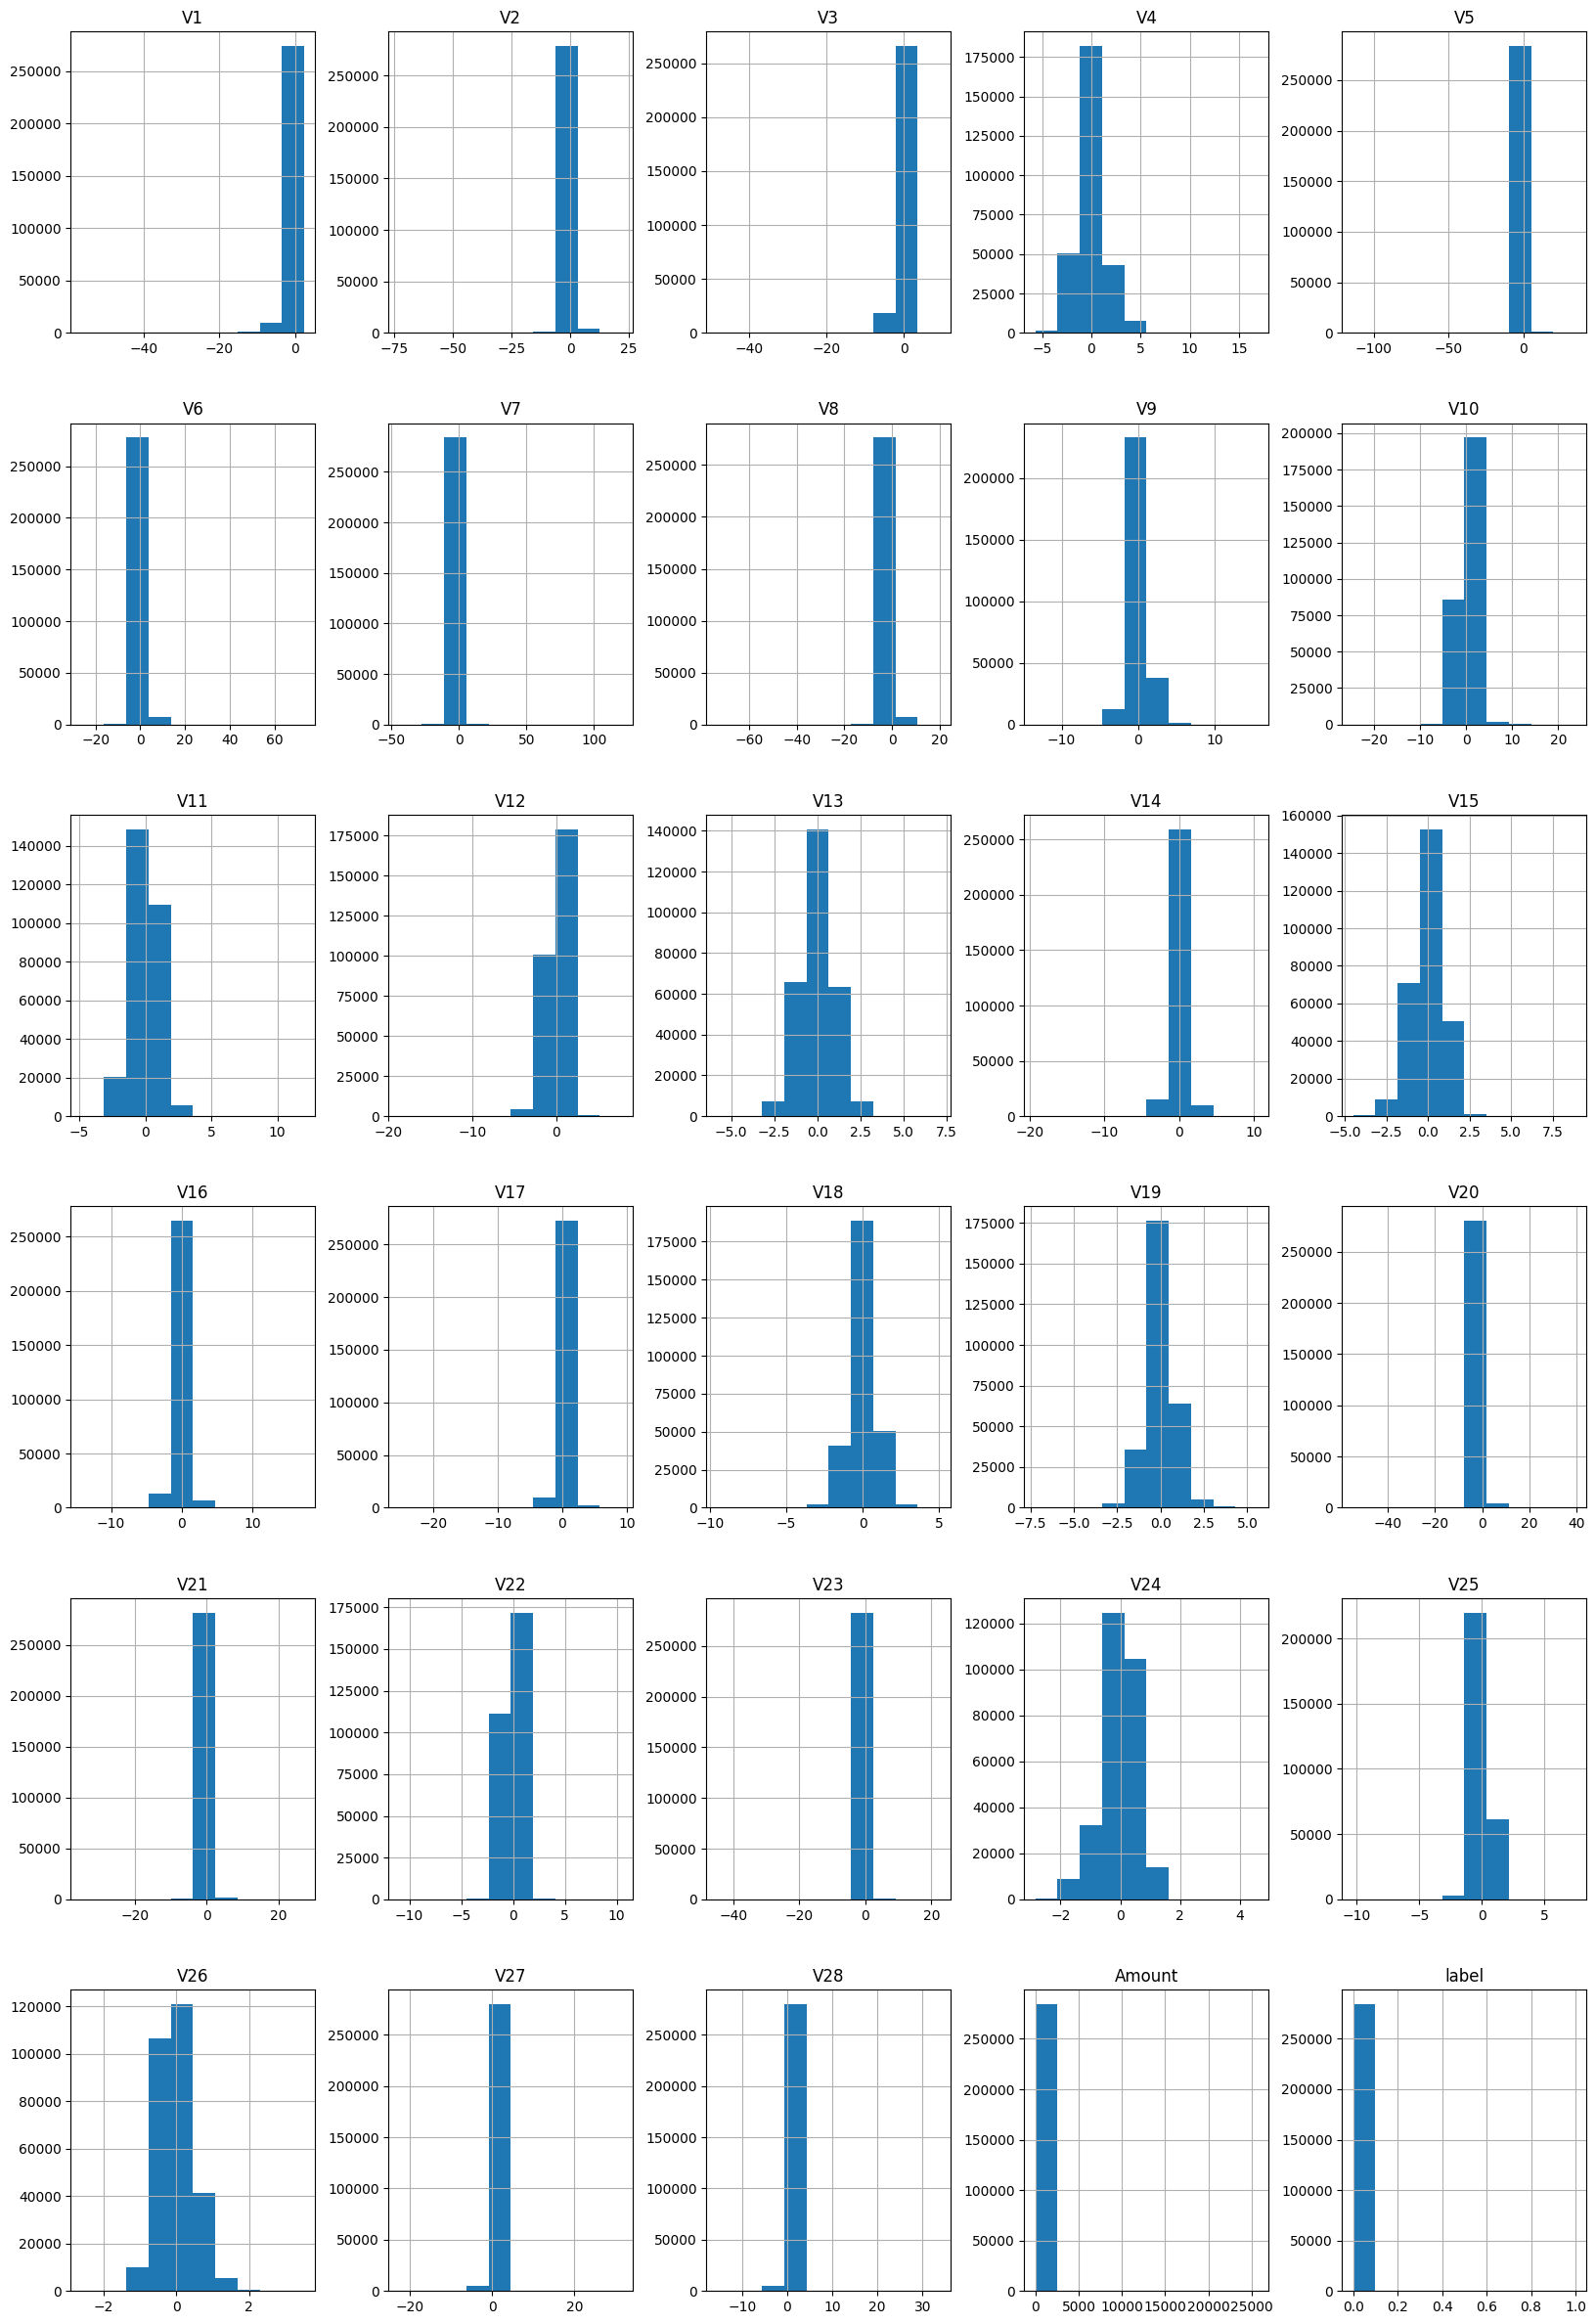

In [10]:
# Convert PySpark DataFrame to Pandas DataFrame
data_pd = csv_data.toPandas()

# Plot histograms of all columns
data_pd.hist(figsize=(20,30))

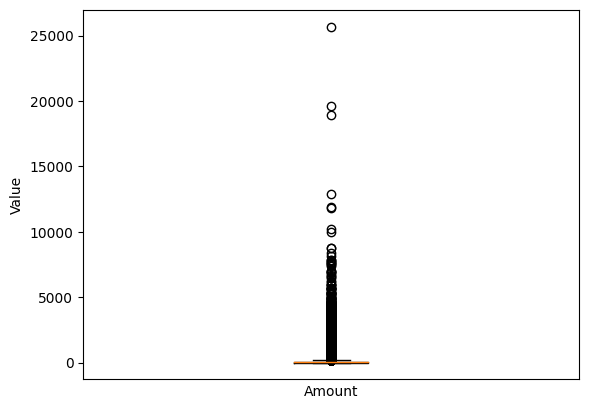

In [11]:
# Extract the "Amount" column and convert it to a list
amount_list = csv_data.select("Amount").rdd.flatMap(lambda x: x).collect()

# Create a boxplot of the "Amount" values
plt.boxplot(amount_list)

# Add x and y axis labels
plt.xlabel("Amount")
plt.ylabel("Value")
plt.xticks([])
# Display the plot
plt.show()

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


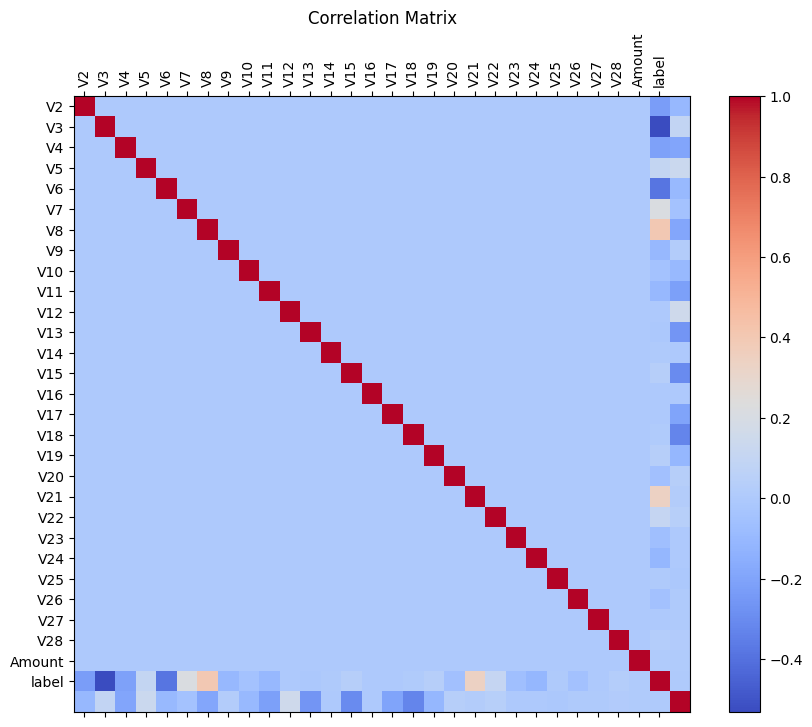

In [12]:
# Define the vector assembler
vec_assembler = VectorAssembler(inputCols=csv_data.columns, outputCol="features")

# Transform the data and select only the features column
data_assembled = vec_assembler.transform(csv_data).select("features")

# Compute the correlation matrix
cr_matrix = Correlation.corr(data_assembled, "features").collect()[0][0]
cr_matrix_array = cr_matrix.toArray()


# Display the matrix with column names and count
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
im = ax.matshow(cr_matrix_array, cmap="coolwarm")

# Set the tick labels with rotation angle
ax.set_xticks(range(len(csv_data.columns)-1))
ax.set_xticklabels(csv_data.columns[1:], rotation=90)
ax.set_yticks(range(len(csv_data.columns)-1))
ax.set_yticklabels(csv_data.columns[1:], rotation=0)

# Add colorbar
cbar = fig.colorbar(im)

# Add title
plt.title("Correlation Matrix")

# Show plot
plt.show()

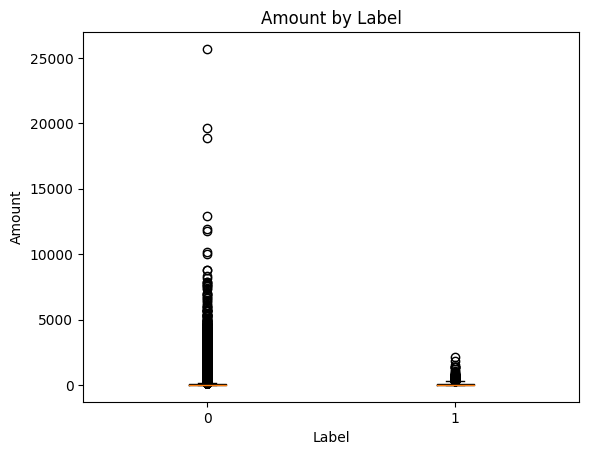

In [13]:
# Convert the data to a Pandas DataFrame
df = csv_data.select("Amount", "label").toPandas()

# Group the data by label and extract the Amount values
groups = df.groupby("label")["Amount"].apply(list)

# Create the boxplot with grouped data
fig, ax = plt.subplots()
ax.boxplot(groups.values, positions=range(1, len(groups)+1))
ax.set_xticklabels(groups.index)
ax.set_xlabel("Label")
ax.set_ylabel("Amount")
ax.set_title("Amount by Label")

# Display the plot
plt.show()


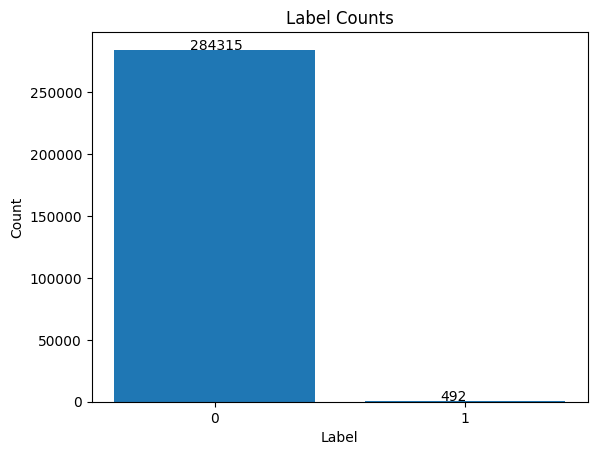

In [14]:
label_counts = df['label'].value_counts()
labels = label_counts.index
counts = label_counts.values

plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1]) 
plt.title('Label Counts')

for i, v in enumerate(counts):
    plt.text(i - 0.1, v + 100, str(v))
plt.show()

# **Logistic Regression:** 

In [15]:
# Normalize the 'amount' column
vec_assembler = VectorAssembler(inputCols=['Amount'], outputCol='amount_vec')
csv_data = vec_assembler.transform(csv_data)

std_scaler = StandardScaler(inputCol='amount_vec', outputCol='amount_scaled')
std_scaler_model = std_scaler.fit(csv_data)
csv_data = std_scaler_model.transform(csv_data)

# Drop the original 'amount' and 'amount_vec' columns
csv_data = csv_data.drop('Amount').drop('amount_vec')

# View the transformed data
csv_data.show(5)

+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----+--------------------+
|          V1|          V2|         V3|          V4|          V5|          V6|          V7|          V8|          V9|         V10|         V11|         V12|         V13|         V14|         V15|         V16|         V17|         V18|         V19|         V20|         V21|         V22|         V23|         V24|         V25|         V26|         V27|         V28|label|       amount_scaled|
+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

In [16]:
# Split the data into training and testing datasets
(trainingData, testData) = csv_data.randomSplit([0.7, 0.3], seed=1234)

# Print the number of examples in each dataset
print(f"training examples Count: {trainingData.count()}")
print(f"testing examples count: {testData.count()}")

training examples Count: 199739
testing examples count: 85068


In [17]:
# Prepare the data for modeling by assembling features into a vector
vec_assembler = VectorAssembler(inputCols=csv_data.columns[:28] + csv_data.columns[29:], outputCol="features")

In [18]:
# Get the input column names of the VectorAssembler
input_cols = vec_assembler.getInputCols()
print(input_cols)   # print the column names in assembler

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'amount_scaled']


In [19]:
# index the label column
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")

In [20]:
# Transform the training and testing data by assembling features and converting labels
training_data = vec_assembler.transform(trainingData)
testing_data = vec_assembler.transform(testData)

In [21]:
# Train a logistic regression model with default hyperparameters on the training data
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(training_data)

In [22]:
# Evaluate the model
predictions = model.transform(testing_data)
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)

# Print the AUC score
print(f"The AUC of the model is {auc:.3f}")

The AUC of the model is 0.500


In [23]:
# Calculate the metrics for the predictions
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_model_accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
lr_model_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
lr_model_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
lr_model_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy of the Logistic Regresssion Model is: {lr_model_accuracy:.3f}")
print(f"Precision of the Logistic Regresssion Model is: {lr_model_precision:.3f}")
print(f"Recall of the Logistic Regresssion Model is: {lr_model_recall:.3f}")
print(f"F1-score of the Logistic Regresssion Model is: {lr_model_f1_score:.3f}")

Accuracy of the Logistic Regresssion Model is: 0.998
Precision of the Logistic Regresssion Model is: 0.997
Recall of the Logistic Regresssion Model is: 0.998
F1-score of the Logistic Regresssion Model is: 0.997


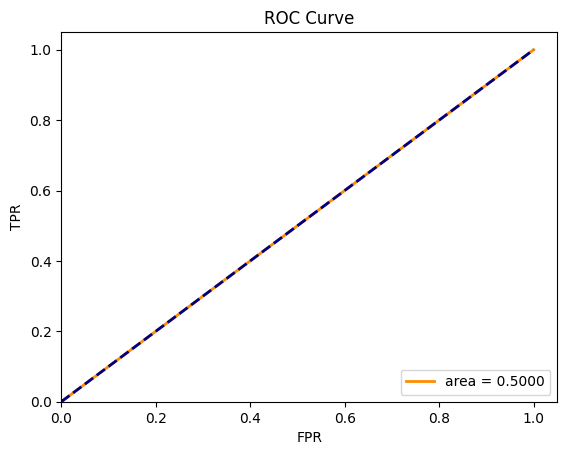

In [24]:
from sklearn.metrics import auc
# Convert the predictions to an RDD
preds = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(preds.map(lambda x: x[1]).collect(), preds.map(lambda x: x[0]).collect())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='area = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Define a grid of hyperparameters to tune using cross-validation
param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

In [26]:
# Define a cross-validator with 3 folds to select the best hyperparameters using AUC score
cross_validator = CrossValidator(estimator=lr,
estimatorParamMaps=param_grid,
evaluator=BinaryClassificationEvaluator(),
numFolds=3)

In [27]:
# Create a pipeline to assemble features, convert labels, and perform cross-validation
pipeline = Pipeline(stages=[vec_assembler, label_indexer, cross_validator])

In [28]:
# Fit the pipeline on the training data to select the best hyperparameters and train a model
pipeline_model = pipeline.fit(trainingData)

In [29]:
# Evaluate the model on the testing data using AUC score as the evaluation metric
predictions = pipeline_model.transform(testData)
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)
print(f"The AUC of the model is {auc:.3f}")

The AUC of the model is 0.975


In [30]:
# Calculate the metrics for the predictions
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_model_accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
lr_model_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
lr_model_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
lr_model_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy of the Logistic Regresssion Model is: {lr_model_accuracy:.3f}")
print(f"Precision of the Logistic Regresssion Model is: {lr_model_precision:.3f}")
print(f"Recall of the Logistic Regresssion Model is: {lr_model_recall:.3f}")
print(f"F1-score of the Logistic Regresssion Model is: {lr_model_f1_score:.3f}")

Accuracy of the Logistic Regresssion Model is: 0.999
Precision of the Logistic Regresssion Model is: 0.999
Recall of the Logistic Regresssion Model is: 0.999
F1-score of the Logistic Regresssion Model is: 0.999


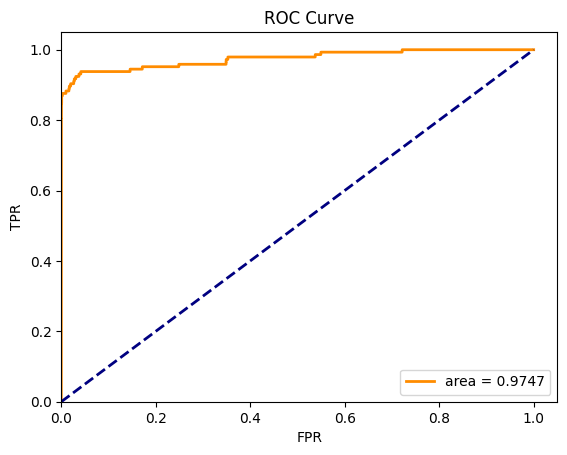

In [31]:
from sklearn.metrics import auc
# Convert the predictions to an RDD
preds = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(preds.map(lambda x: x[1]).collect(), preds.map(lambda x: x[0]).collect())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='area = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest:

In [21]:
# import necessary libraries
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [22]:
# Load the data
csv_data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/content/drive/MyDrive/creditcard.csv")

In [23]:
# Clean and preprocess the data
csv_data = csv_data.drop("Time") # Drop the Time column
csv_data = csv_data.withColumnRenamed("class", "label") # Rename the Class column to label

In [24]:
# Normalize the 'amount' column
assembler = VectorAssembler(inputCols=['Amount'], outputCol='amount_vec')
csv_data = assembler.transform(csv_data)

std_scaler = StandardScaler(inputCol='amount_vec', outputCol='amount_scaled')
std_scaler_model = std_scaler.fit(csv_data)
csv_data = std_scaler_model.transform(csv_data)

# Drop the original 'amount' and 'amount_vec' columns
csv_data = csv_data.drop('Amount').drop('amount_vec')

# View the transformed data
csv_data.show(5)

+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----+--------------------+
|          V1|          V2|         V3|          V4|          V5|          V6|          V7|          V8|          V9|         V10|         V11|         V12|         V13|         V14|         V15|         V16|         V17|         V18|         V19|         V20|         V21|         V22|         V23|         V24|         V25|         V26|         V27|         V28|label|       amount_scaled|
+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

In [25]:
# Select only the features and the label
csv_data = csv_data.select([col(c).alias(c.lower()) for c in csv_data.columns])
cols = csv_data.columns
cols.remove('label')
assembler = VectorAssembler(inputCols=cols, outputCol='features')
csv_data = assembler.transform(csv_data)
csv_data = csv_data.select(['features', 'label'])


In [26]:
# Split the data into train and test sets
train_set, test_set = csv_data.randomSplit([0.7, 0.3], seed=1234)

In [27]:
# Define the random forest classifier
rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=10)

In [28]:
# Train the model
rf_model = rf.fit(train_set)

In [29]:
# Evaluate the model on the test set
predictions = rf_model.transform(test_set)
classification_evaluator = BinaryClassificationEvaluator(labelCol='label')
auc = classification_evaluator.evaluate(predictions)

# Print the AUC score
print(f"The AUC of the model is {auc:.3f}")

The AUC of the model is 0.962


In [30]:
# Calculate the metrics for the predictions
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_model_accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
rf_model_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
rf_model_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
rf_model_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy of the Random Forest Model is: {rf_model_accuracy:.3f}")
print(f"Precision of the  Random Forest Model is: {rf_model_precision:.3f}")
print(f"Recall of the  Random Forest Model is: {rf_model_recall:.3f}")
print(f"F1-score of the  Random Forest Model is: {rf_model_f1_score:.3f}")

Accuracy of the Random Forest Model is: 0.999
Precision of the  Random Forest Model is: 0.999
Recall of the  Random Forest Model is: 0.999
F1-score of the  Random Forest Model is: 0.999


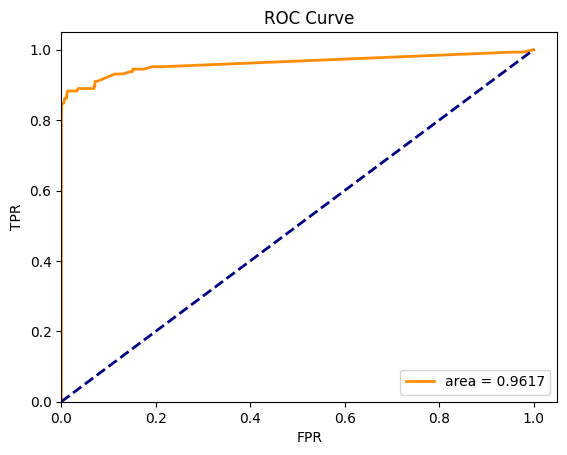

In [31]:
from sklearn.metrics import auc
# Convert the predictions to an RDD
preds = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(preds.map(lambda x: x[1]).collect(), preds.map(lambda x: x[0]).collect())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='area = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [32]:
# Define the parameter grid to search over
parameter_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt"]) \
    .build()

# Define the cross-validator
cross_validator = CrossValidator(estimator=rf, estimatorParamMaps=parameter_grid, evaluator=evaluator, numFolds=5)

# Fit the cross-validator to the training data
cvModel = cross_validator.fit(train_set)

# Make predictions on the test data
predictions = cvModel.transform(test_set)

# Evaluate the model using the binary classification evaluator
auc = evaluator.evaluate(predictions)

# Print the AUC score
print(f"The AUC of the model is {auc:.3f}")

The AUC of the model is 1.000


In [33]:
# Calculate the metrics for the predictions
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_model_accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
rf_model_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
rf_model_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
rf_model_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy of the Random Forest Model is: {rf_model_accuracy:.3f}")
print(f"Precision of the  Random Forest Model is: {rf_model_precision:.3f}")
print(f"Recall of the  Random Forest Model is: {rf_model_recall:.3f}")
print(f"F1-score of the  Random Forest Model is: {rf_model_f1_score:.3f}")

Accuracy of the Random Forest Model is: 1.000
Precision of the  Random Forest Model is: 1.000
Recall of the  Random Forest Model is: 1.000
F1-score of the  Random Forest Model is: 1.000


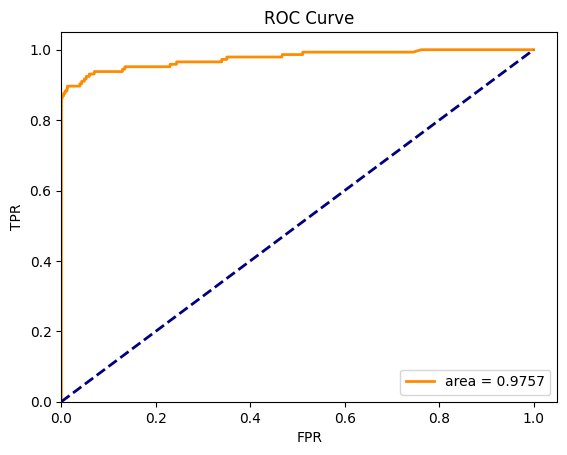

In [34]:
from sklearn.metrics import auc
# Convert the predictions to an RDD
preds = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(preds.map(lambda x: x[1]).collect(), preds.map(lambda x: x[0]).collect())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='area = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **Gradient Boosted Trees (GBTs):**

In [35]:
# import necessary libraries
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [36]:
# Load the data
csv_data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/content/drive/MyDrive/creditcard.csv")

In [37]:
# Clean and preprocess the data
csv_data = csv_data.drop("Time") # Drop the Time column
csv_data = csv_data.withColumnRenamed("class", "label") # Rename the Class column to label

In [38]:
# Normalize the 'amount' column
vect_assembler = VectorAssembler(inputCols=['Amount'], outputCol='amount_vec')
csv_data = vect_assembler.transform(csv_data)

std_scaler = StandardScaler(inputCol='amount_vec', outputCol='amount_scaled')
std_scaler_model = std_scaler.fit(csv_data)
csv_data = std_scaler_model.transform(csv_data)

# Drop the original 'amount' and 'amount_vec' columns
csv_data = csv_data.drop('Amount').drop('amount_vec')

# View the transformed data
csv_data.show(5)

+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----+--------------------+
|          V1|          V2|         V3|          V4|          V5|          V6|          V7|          V8|          V9|         V10|         V11|         V12|         V13|         V14|         V15|         V16|         V17|         V18|         V19|         V20|         V21|         V22|         V23|         V24|         V25|         V26|         V27|         V28|label|       amount_scaled|
+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

In [39]:
# Select only the features and the label
csv_data = csv_data.select([col(c).alias(c.lower()) for c in csv_data.columns])
cols = csv_data.columns
cols.remove('label')
assembler = VectorAssembler(inputCols=cols, outputCol='features')
csv_data = assembler.transform(csv_data)
csv_data = csv_data.select(['features', 'label'])

In [40]:
# Split the data into training and testing sets
(trainingData, testData) = csv_data.randomSplit([0.7, 0.3], seed=42)

In [41]:
# Define the GBTs model
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)

In [42]:
# Fit the model on the training data
gbt_model = gbt.fit(trainingData)

In [43]:

# Use the trained model to make predictions on the test data
predictions = gbt_model.transform(testData)

# Define an evaluator to calculate the area under the ROC curve (AUC)
evaluator = BinaryClassificationEvaluator(labelCol='label')

# Calculate the AUC of the model
auc = evaluator.evaluate(predictions)

# Print the AUC score with three decimal places
print(f"The AUC of the model is {auc:.3f}")


The AUC of the model is 0.986


In [51]:
# Calculate the metrics for the predictions
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
gbt_model_accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
gbt_model_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
gbt_model_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
gbt_model_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy of the GBT Model is: {gbt_model_accuracy:.3f}")
print(f"Precision of the GBT Model is: {gbt_model_precision:.3f}")
print(f"Recall of the GBT Model is: {gbt_model_recall:.3f}")
print(f"F1-score of the GBT Model is: {gbt_model_f1_score:.3f}")


Accuracy of the GBT Model is: 0.999
Precision of the GBT Model is: 0.999
Recall of the GBT Model is: 0.999
F1-score of the GBT Model is: 0.999


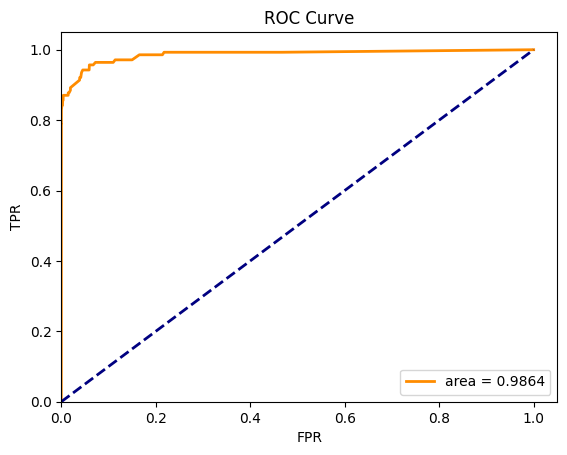

In [45]:
from sklearn.metrics import auc
# Convert the predictions to an RDD
preds = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(preds.map(lambda x: x[1]).collect(), preds.map(lambda x: x[0]).collect())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='area = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
# Define the hyperparameter grid using the ParamGridBuilder
parameter_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [16, 32]) \
    .build()

# Create a CrossValidator object with the GBTClassifier model, hyperparameter grid, binary classification evaluator, and number of folds
cross_validator= CrossValidator(estimator=gbt, estimatorParamMaps=parameter_grid, evaluator=evaluator, numFolds=5)

In [47]:
# Fit the CrossValidator to the training data
cross_validator_model = cross_validator.fit(trainingData)

In [48]:
# Get the best model from the cross-validation process
bestModel = cross_validator_model.bestModel

# Use the best model to make predictions on the test data
predictions = bestModel.transform(testData)

# Evaluate the performance of the model by calculating the AUC
auc = evaluator.evaluate(predictions)

# Print the AUC score
print(f"The AUC of the model is {auc:.3f}")


The AUC of the model is 0.999


In [52]:
# Calculate the metrics for the predictions
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
gbt_model_accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
gbt_model_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
gbt_model_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
gbt_model_f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy of the GBT Model is: {gbt_model_accuracy:.3f}")
print(f"Precision of the GBT Model is: {gbt_model_precision:.3f}")
print(f"Recall of the GBT Model is: {gbt_model_recall:.3f}")
print(f"F1-score of the GBT Model is: {gbt_model_f1_score:.3f}")


Accuracy of the GBT Model is: 0.999
Precision of the GBT Model is: 0.999
Recall of the  Random Forest Model is: 0.999
F1-score of the GBT Model is: 0.999


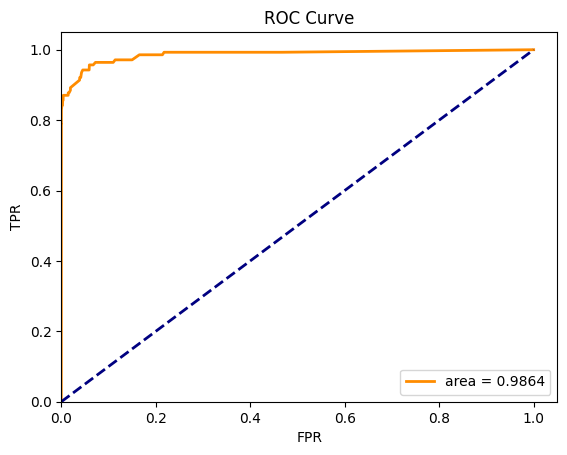

In [50]:
from sklearn.metrics import auc
# Convert the predictions to an RDD
preds = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(preds.map(lambda x: x[1]).collect(), preds.map(lambda x: x[0]).collect())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='area = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()